<a href="https://colab.research.google.com/github/Ahmedhasssan/LP-Seg-UNET/blob/main/Seg_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

*In this challenge I built a deep learning solution capable of segmenting turtles on synthetic images.

***Training data***

The training data consists of 30 256x256 images of the same synthetic turtle pasted on background images artificially generated by BigGAN (https://arxiv.org/abs/1809.11096).

Each image comes with the ground truth per-pixel segmentation mask which you can leverage for your training setup. We strongly recommend that you treat the provided task as semantic segmentation with 2 classes -- foreground (turtle) and background (everything else).

***Test data***

There will only be a single test image without the provided GT.


***Colab setup***

* To use GPU, go to `Runtime -> Change Runtime Type -> GPU`

In [ ]:
# comment the following line if you are working outside of a notebook environment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [ ]:
# Used to download any files you need for your solution from Google Drive
import gdown
gdown.download("https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML", "turtle.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML
To: /content/turtle.png
100%|██████████| 692k/692k [00:00<00:00, 6.96MB/s]


'turtle.png'

In [ ]:
# read and visualise the turtle image
turtle_image = Image.open('./turtle.png')
# it is a 4-channel RGB+Alpha image of size 2394x1800
print(turtle_image.mode, turtle_image.size)

RGBA (2394, 1800)


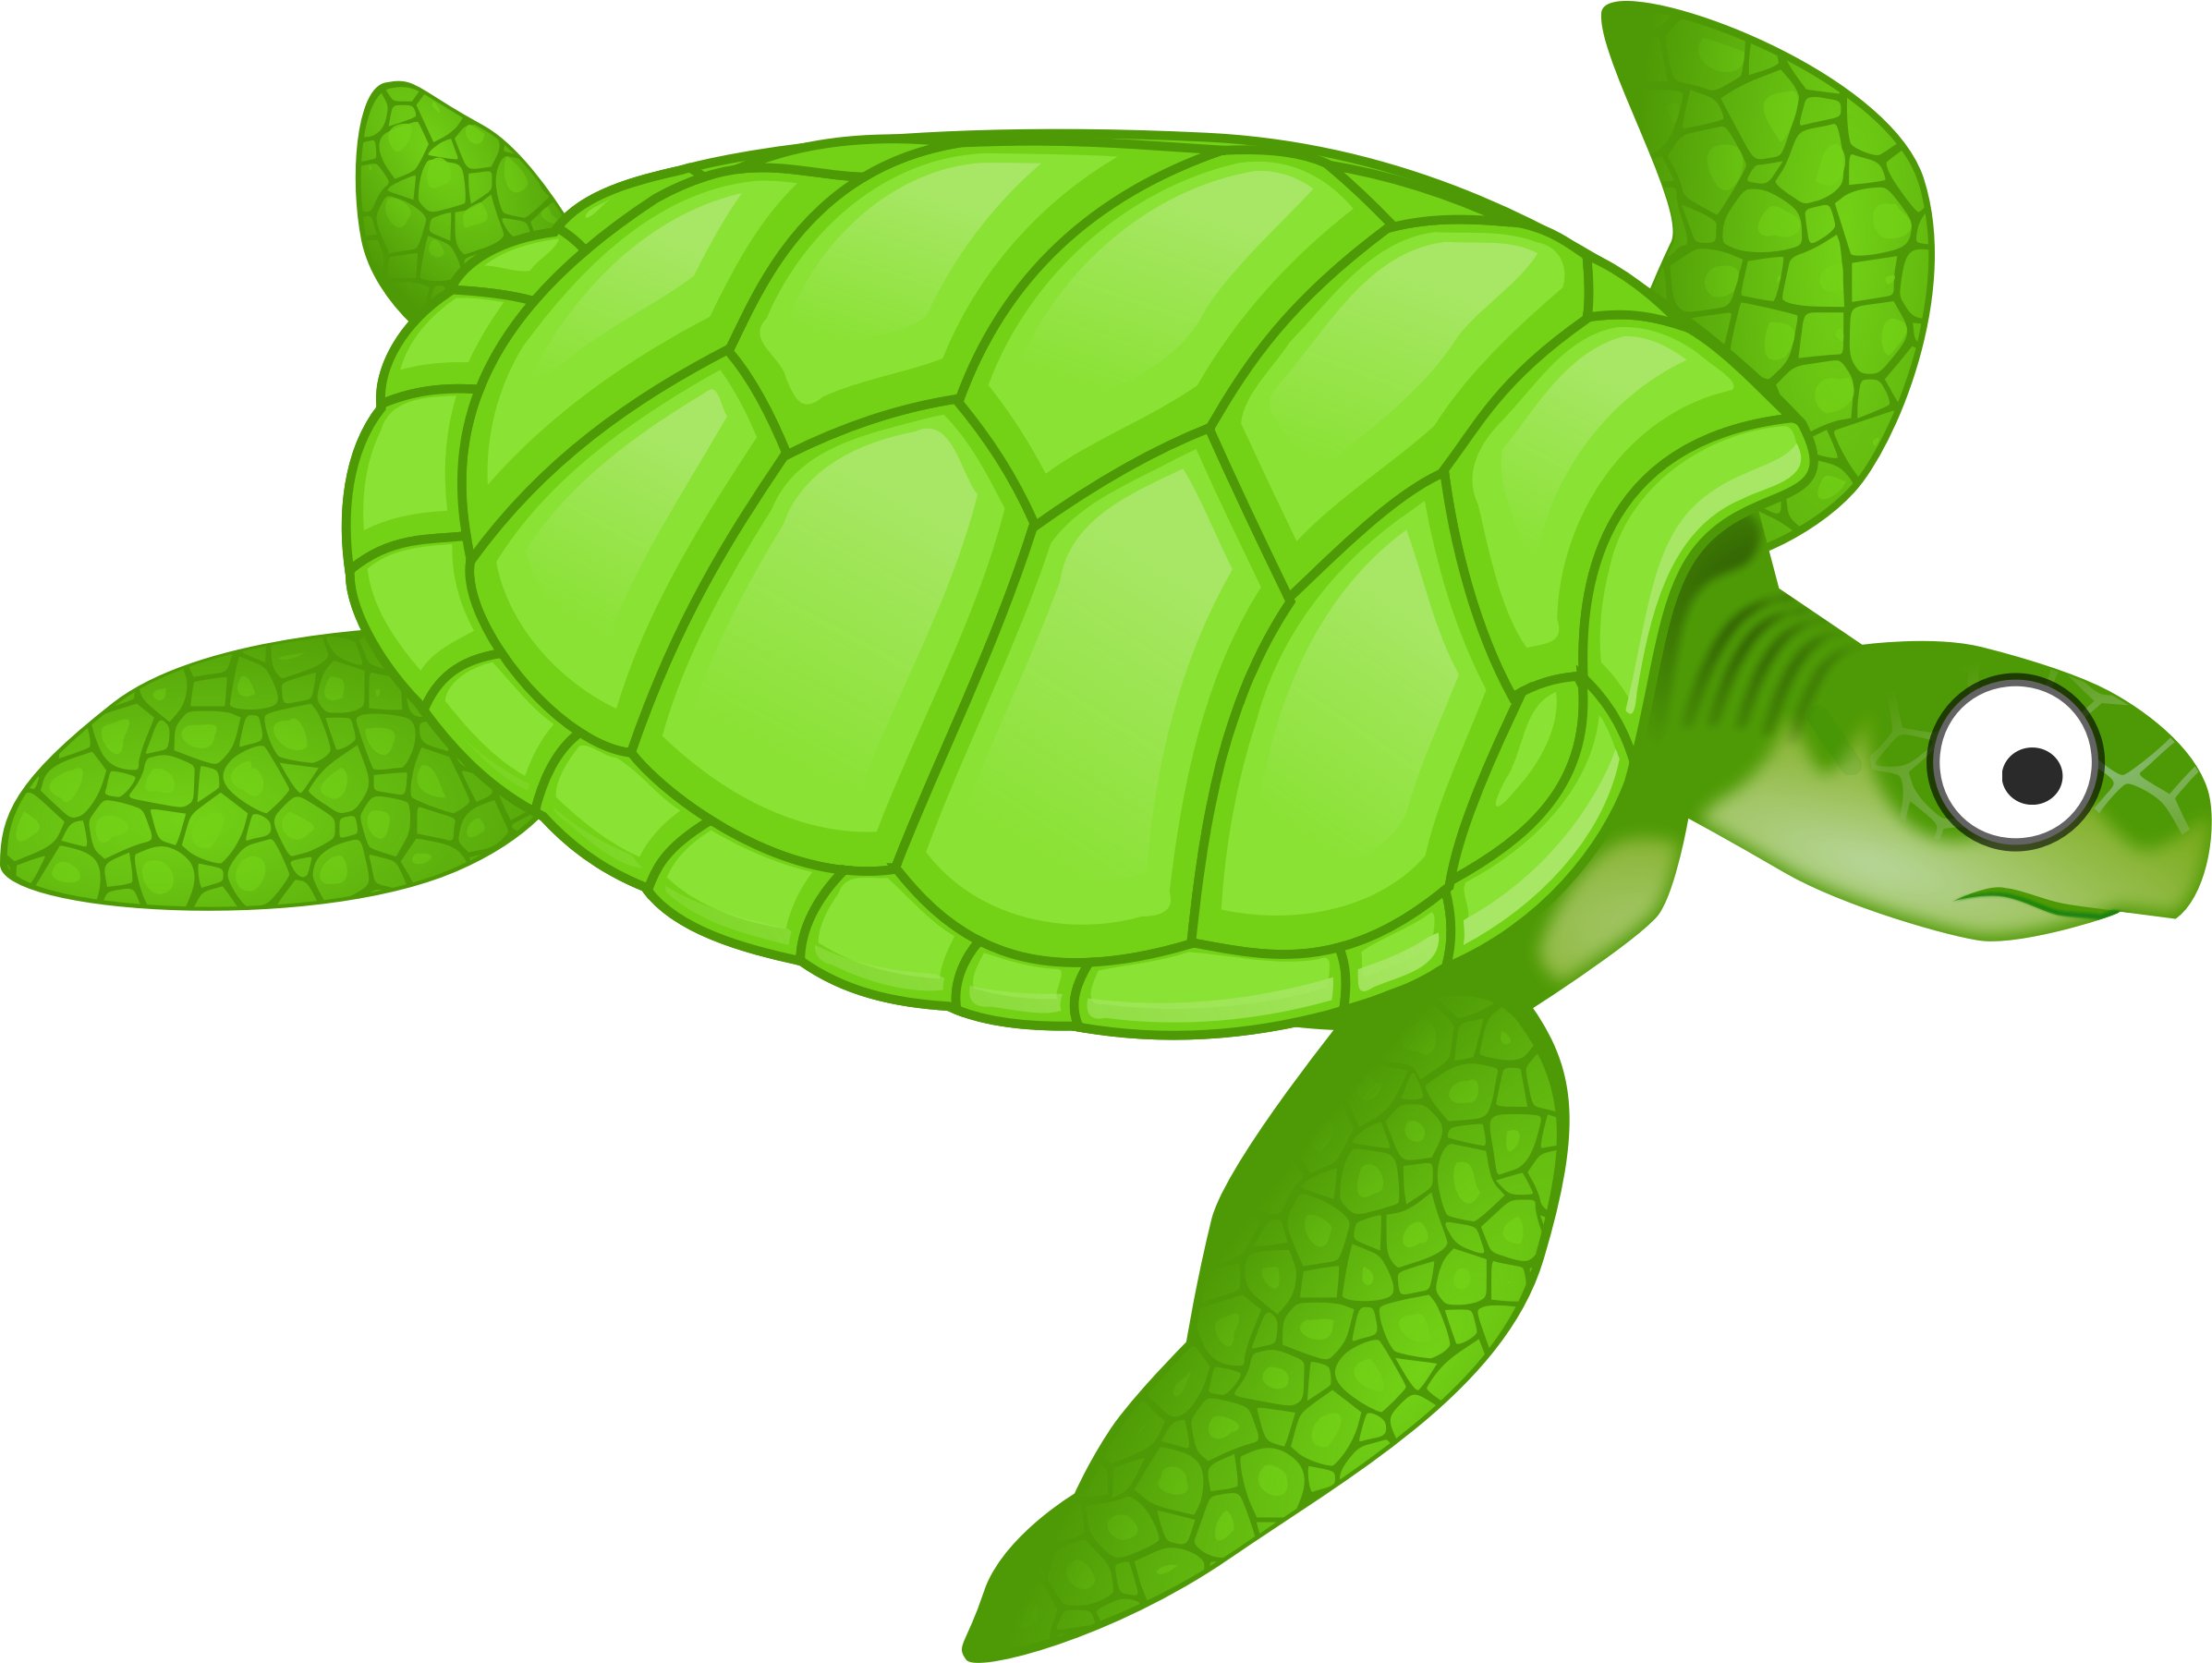

In [ ]:
turtle_image

In [ ]:
# to create the training set, we will resize the turtle image to 256x256
turtle_image_256x256 = turtle_image.resize((256, 256))

# Background Images

As written above, we will use a generative adversarial network called "BigGAN" pre-trained on ImageNet to create a set of background images

In [ ]:
# first, we need to install the python package called `pytorch_pretrained_biggan` (https://github.com/huggingface/pytorch-pretrained-BigGAN)
# if in the notebook environment, please uncomment the following line to install this package
!pip install pytorch_pretrained_biggan
# there might be some errors related to pip's dependency resolver which you can safely ignore

In [ ]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    convert_to_images,
    one_hot_from_int,
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

BigGAN is a memory-intensive network.

To save time and memory, we will only generate 30 different background images.
Feel free to change this setup as needed.

In [ ]:
# load the 256x256 model
model = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()

# every time we will run with batch size of 3 in order to not run out of memory
num_passes = 10
batch_size = 3

# default noise value from the provided repository
truncation = 0.4

background_images = []

for _ in range(num_passes):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        background_images.extend(convert_to_images(output))

# We won't need the GAN model anymore,
# so we can safely delete it and free up some memory
del model
torch.cuda.empty_cache()

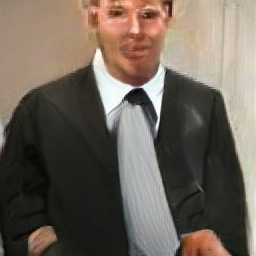

In [ ]:
# Let's see how one of the images look like
random.choice(background_images)

# Training Set
Given 30 background images and the turtle image, we will paste the turtle onto the background images.

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
tensor_transform = transforms.ToTensor()

def random_paste(background_image, turtle_image, min_scale=0.25, max_scale=0.65):
    """Randomly scales and pastes the turtle image onto the background image"""

    w, h = turtle_image.size
    # first, we will randomly downscale the turtle image
    new_w = int(random.uniform(min_scale, max_scale) * w)
    new_h = int(random.uniform(min_scale, max_scale) * h)
    resized_turtle_image = turtle_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(0, w - new_w)
    start_h = random.randint(0, h - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (w, h))

    # and paste the resized turtle onto it, preserving the mask
    canvas_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)

    # Turtle image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')
    # finally, will paste the resized turtle onto the background image
    background_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)
    return background_image, canvas_image

**Data Augmentation:** I have incorporated horizontal flip and 45-degree rotation to improve the model learnability.

In [ ]:
training_set = [] ## Training Data Generation

for background_image in background_images:
  aug_image, aug_mask = random_paste(background_image.copy(), turtle_image_256x256.copy())

  training_pair = [
      tensor_transform(aug_image)[:3],
      tensor_transform(aug_mask)[-1:] > 0.0,
  ]
  training_set.append(training_pair)
  ### Added this part to incorporate some augmentation and enhance data
  training_pair = [
      tensor_transform(torchvision.transforms.functional.hflip(aug_image))[:3],
      tensor_transform(torchvision.transforms.functional.hflip(aug_mask))[-1:] > 0.0,
  ]
  training_set.append(training_pair)
  ### Added this part to incorporate some augmentation and enhance data
  training_pair = [
      tensor_transform(torchvision.transforms.functional.rotate(aug_image,45))[:3],
      tensor_transform(torchvision.transforms.functional.rotate(aug_mask,45))[-1:] > 0.0,
  ]
  training_set.append(training_pair)

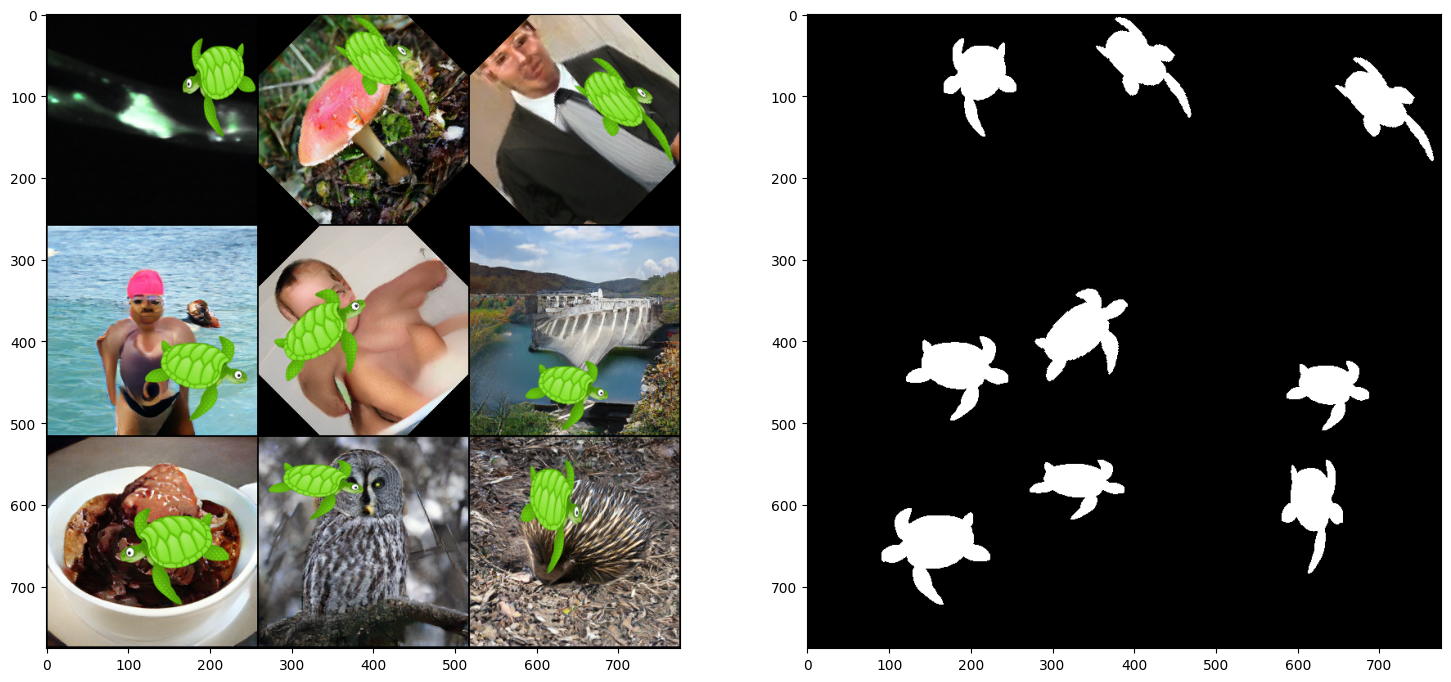

In [ ]:
# Let's visualise some subset of the training set
sample_indices = np.random.choice(len(training_set), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = training_set[i]
    sample_images.append(image)
    sample_masks.append(mask)

plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

# Test Image
Now, let's load the test image. As mentioned above, it is of a slightly higher 512x512 resolution.

Downloading...
From: https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa
To: /content/test.png
100%|██████████| 413k/413k [00:00<00:00, 4.55MB/s]

RGB (512, 512)


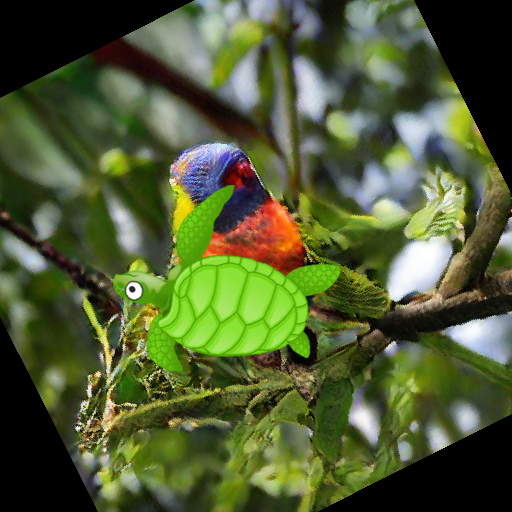

In [ ]:
gdown.download("https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa", "test.png", quiet=False)
test_image = Image.open('./test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

# Task 1: Predicting segmentation mask

*This is where you need to implement your deep learning solution. Your approach must output a result at the native 512x512 resolution of the test image.*

**Learning rate Scheduler:** This adjusts the learning rate after certain epochs

In [ ]:
### LR_Schedular

import math
from  torch.optim.lr_scheduler import _LRScheduler

def dir_exists(path):
    if not os.path.exists(path):
            os.makedirs(path)

class Poly(_LRScheduler):
    def __init__(self, optimizer, num_epochs, iters_per_epoch=0, warmup_epochs=0, last_epoch=-1):
        self.iters_per_epoch = iters_per_epoch
        self.cur_iter = 0
        self.N = num_epochs * iters_per_epoch
        self.warmup_iters = warmup_epochs * iters_per_epoch
        super(Poly, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        T = self.last_epoch * self.iters_per_epoch + self.cur_iter
        factor =  pow((1 - 1.0 * T / self.N), 0.9)
        if self.warmup_iters > 0 and T < self.warmup_iters:
            factor = 1.0 * T / self.warmup_iters

        self.cur_iter %= self.iters_per_epoch
        self.cur_iter += 1
        return [base_lr * factor for base_lr in self.base_lrs]


**BaseTrainer:** This includes the basics of training part all the training essentials

In [ ]:
from numpy.lib.polynomial import poly
import os
import logging
import json
import math
import torch
import datetime
from torch.utils import tensorboard

class BaseTrainer:
    def __init__(self, model, loss, train_loader, val_loader=None, train_logger=None):
        self.model = model
        self.loss = loss
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_logger = train_logger
        self.logger = logging.getLogger(self.__class__.__name__)
        self.do_validation = True
        self.start_epoch = 1
        self.improved = False
        if not os.path.exists('./save'):
          os.mkdir('./save')
          os.mkdir('./save/run/')

        self.device, availble_gpus = self.get_available_devices(1)
        self.model = torch.nn.DataParallel(self.model, device_ids=availble_gpus)
        self.model.to(self.device)

        self.epochs = 200
        self.save_period = 10

        if isinstance(self.model, torch.nn.DataParallel):
            trainable_params = [{'params': filter(lambda p:p.requires_grad, self.model.module.get_decoder_params())},
                                {'params': filter(lambda p:p.requires_grad, self.model.module.get_backbone_params()),
                                'lr': 0.01 / 10}]
        else:
            trainable_params = [{'params': filter(lambda p:p.requires_grad, self.model.get_decoder_params())},
                                {'params': filter(lambda p:p.requires_grad, self.model.get_backbone_params()),
                                'lr': 0.01 / 10}]

        self.optimizer = torch.optim.SGD(trainable_params,lr= 0.01,weight_decay= 1e-4, momentum= 0.9)
        self.lr_scheduler = Poly(self.optimizer, self.epochs, len(train_loader))

        # Saving Checkpoints
        start_time = datetime.datetime.now().strftime('%m-%d_%H-%M')
        self.checkpoint_dir = os.path.join("./save", start_time)
        dir_exists(self.checkpoint_dir)

    def get_available_devices(self, n_gpu):
        sys_gpu = torch.cuda.device_count()
        if sys_gpu == 0:
            n_gpu = 0
        elif n_gpu > sys_gpu:
            n_gpu = sys_gpu
        device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
        available_gpus = list(range(n_gpu))
        return device, available_gpus

    def train(self):
        for epoch in range(self.start_epoch, self.epochs+1):
            results = self.train_epoch(epoch)

            # Save Checkpoints
            if epoch % self.save_period == 0:
                self.save_checkpoint(epoch)

    def save_checkpoint(self, epoch):
        state = {
            'arch': type(self.model).__name__,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        filename = os.path.join(self.checkpoint_dir, f'checkpoint-epoch{epoch}.pth')
        self.logger.info(f'\nSaving a checkpoint: {filename} ...')
        torch.save(state, filename)

    def train_epoch(self, epoch):
        raise NotImplementedError

    def eval_metrics(self, output, target):
        raise NotImplementedError


In [ ]:
#### Metrics for evaluation
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = np.multiply(val, weight)
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum = np.add(self.sum, np.multiply(val, weight))
        self.count = self.count + weight
        self.avg = self.sum / self.count

    @property
    def value(self):
        return self.val

    @property
    def average(self):
        return np.round(self.avg, 5)

def batch_pix_accuracy(predict, target, labeled):
    pixel_labeled = labeled.sum()
    pixel_correct = ((predict == target) * labeled).sum()
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct.cpu().numpy(), pixel_labeled.cpu().numpy()

def batch_intersection_union(predict, target, num_class, labeled):
    predict = predict * labeled.long()
    intersection = predict * (predict == target).long()

    area_inter = torch.histc(intersection.float(), bins=num_class, max=num_class, min=1)
    area_pred = torch.histc(predict.float(), bins=num_class, max=num_class, min=1)
    area_lab = torch.histc(target.float(), bins=num_class, max=num_class, min=1)
    area_union = area_pred + area_lab - area_inter
    assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
    return area_inter.cpu().numpy(), area_union.cpu().numpy()

def eval_metrics(output, target, num_class):
    _, predict = torch.max(output.data, 1)
    predict = predict + 1
    target = target + 1
    labeled = (target > 0) * (target <= num_class)
    correct, num_labeled = batch_pix_accuracy(predict, target, labeled)
    inter, union = batch_intersection_union(predict, target, num_class, labeled)
    return [np.round(correct, 5), np.round(num_labeled, 5), np.round(inter, 5), np.round(union, 5)]

**Main Training Function**

In [ ]:
import time
from tqdm import tqdm
class Trainer(BaseTrainer):
    def __init__(self, model, loss, train_loader, val_loader=None, train_logger=None, prefetch=True):
        super(Trainer, self).__init__(model, loss, train_loader, val_loader, train_logger)
        self.num_classes = 2

        if self.device ==  torch.device('cpu'): prefetch = False
        self.train_loader = train_loader
        self.val_loader =  val_loader

        torch.backends.cudnn.benchmark = True

    def train_epoch(self, epoch):
        self.model.train()
        tic = time.time()
        self.reset_metrics()
        tbar = tqdm(self.train_loader, ncols=130)
        for batch_idx, (data, target) in enumerate(tbar):
            self.data_time.update(time.time() - tic)
            self.lr_scheduler.step(epoch=epoch-1)
            self.optimizer.zero_grad()
            output = self.model(data)
            target = target.squeeze(1).long().cuda()
            assert output.size()[2:] == target.size()[1:]
            assert output.size()[1] == self.num_classes
            loss = self.loss(output, target)
            if isinstance(self.loss, torch.nn.DataParallel):
                loss = loss.mean()
            loss.backward()
            self.optimizer.step()
            self.total_loss.update(loss.item())

            self.batch_time.update(time.time() - tic)
            tic = time.time()

            # Evaluation
            seg_metrics = eval_metrics(output, target, self.num_classes)
            self.update_seg_metrics(*seg_metrics)
            pixAcc, mIoU, _ = self.get_seg_metrics().values()
            tbar.set_description('TRAIN ({}) | Loss: {:.3f} | Acc {:.2f} mIoU {:.2f} |'.format(epoch,
                                                                      self.total_loss.average,pixAcc, mIoU))

    def reset_metrics(self):
        self.batch_time = AverageMeter()
        self.data_time = AverageMeter()
        self.total_loss = AverageMeter()
        self.total_inter, self.total_union = 0, 0
        self.total_correct, self.total_label = 0, 0
    def update_seg_metrics(self, correct, labeled, inter, union):
        self.total_correct += correct
        self.total_label += labeled
        self.total_inter += inter
        self.total_union += union
    def get_seg_metrics(self):
        pixAcc = 1.0 * self.total_correct / (np.spacing(1) + self.total_label)
        IoU = 1.0 * self.total_inter / (np.spacing(1) + self.total_union)
        mIoU = IoU.mean()
        return {
            "Pixel_Accuracy": np.round(pixAcc, 3),
            "Mean_IoU": np.round(mIoU, 3),
            "Class_IoU": dict(zip(range(self.num_classes), np.round(IoU, 3)))
        }

In [ ]:
import torch.nn as nn
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, ignore_index=255, reduction='mean'):
        super(CrossEntropyLoss2d, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target)
        return loss

**Model Architecture** I have adopted and modified this model from the following Github Repo https://github.com/milesial/Pytorch-UNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
from itertools import chain

def x2conv(in_channels, out_channels, inner_channels=None):
    inner_channels = out_channels // 2 if inner_channels is None else inner_channels
    down_conv = nn.Sequential(
        nn.Conv2d(in_channels, inner_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(inner_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(inner_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))
    return down_conv

class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder, self).__init__()
        self.down_conv = x2conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, ceil_mode=True)

    def forward(self, x):
        x = self.down_conv(x)
        x = self.pool(x)
        return x

class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.up_conv = x2conv(in_channels, out_channels)

    def forward(self, x_copy, x, interpolate=True):
        x = self.up(x)

        if (x.size(2) != x_copy.size(2)) or (x.size(3) != x_copy.size(3)):
            if interpolate:
                # Iterpolating instead of padding
                x = F.interpolate(x, size=(x_copy.size(2), x_copy.size(3)),
                                mode="bilinear", align_corners=True)
            else:
                # Padding in case the incomping volumes are of different sizes
                diffY = x_copy.size()[2] - x.size()[2]
                diffX = x_copy.size()[3] - x.size()[3]
                x = F.pad(x, (diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2))

        # Concatenate
        x = torch.cat([x_copy, x], dim=1)
        x = self.up_conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, freeze_bn=False, **_):
        super(UNet, self).__init__()

        self.start_conv = x2conv(in_channels, 64)
        self.down1 = encoder(64, 128)
        self.down2 = encoder(128, 256)
        self.down3 = encoder(256, 512)
        self.down4 = encoder(512, 1024)

        self.middle_conv = x2conv(1024, 1024)

        self.up1 = decoder(1024, 512)
        self.up2 = decoder(512, 256)
        self.up3 = decoder(256, 128)
        self.up4 = decoder(128, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self._initialize_weights()

        if freeze_bn:
            self.freeze_bn()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

    def forward(self, x):
        x1 = self.start_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.middle_conv(self.down4(x4))

        x = self.up1(x4, x)
        x = self.up2(x3, x)
        x = self.up3(x2, x)
        x = self.up4(x1, x)

        x = self.final_conv(x)
        return x

    def get_backbone_params(self):
        # There is no backbone for unet, all the parameters are trained from scratch
        return []

    def get_decoder_params(self):
        return self.parameters()

    def freeze_bn(self):
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d): module.eval()


**DataLoader:** Used Pytorch libraries to generate the train and test dataloaders.

In [ ]:
training_dataloader = torch.utils.data.DataLoader(dataset=training_set,batch_size=1,shuffle=True)
valid_transform = tensor_transform = transforms.Compose([
    transforms.ToTensor()
])
test_img = [
      valid_transform(test_image)[:3]
  ]
test_dataloader = torch.utils.data.DataLoader(dataset=test_img,batch_size=1,shuffle=False)

**Training of Model:** Mode training with UNet architecture

In [ ]:
# Model
model = UNet(num_classes=2, in_channels=3)
#print(model})
loss = CrossEntropyLoss2d()
# Training
trainer = Trainer(model=model, loss=loss, train_loader=training_dataloader, val_loader=test_dataloader)
trainer.train()

  0%|                                                                                                      | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used in

KeyboardInterrupt: ignored

**Model Saving and Loading:** Saved the model to Gdrive and loaded for the inference

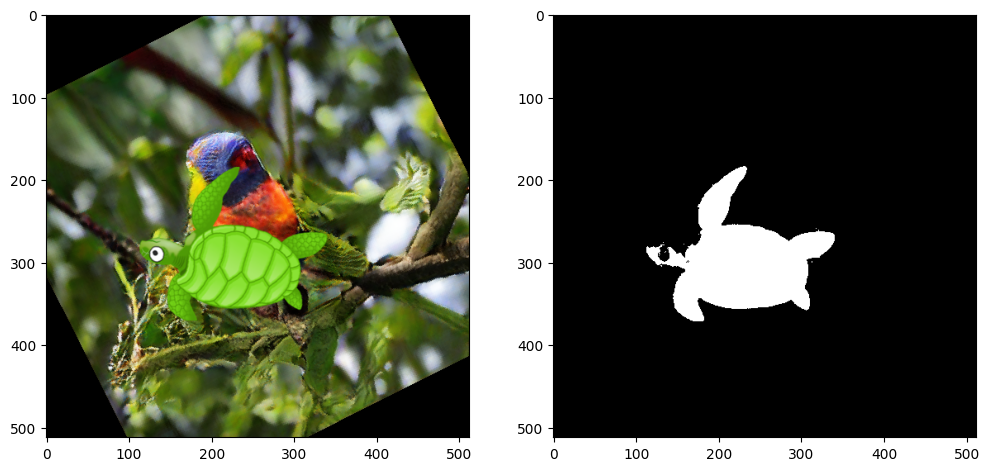

In [ ]:
# TODO: Implement and train the deep model
### Answer: I have provided my implementation above

# TODO: Save the model weights and upload them to Google Drive
import shutil
shutil.copy("/content/save/11-01_01-30/checkpoint-epoch190.pth","/content/drive/MyDrive/Unet/")

load_model_weights = True
if load_model_weights:
    # After uploading your saved model weights to Google Drive, share to
    # "Anyone with the link" and extract FILE_ID from the share link
    # See https://support.google.com/drive/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop
    # for more information
    # Now the weights can be downloaded and used via gdown:
    saved_model_url = "https://drive.google.com/uc?id=1T7uSI1C085laiXEFup7Vcm0VhgQ7tXE-"
    gdown.download(saved_model_url, "saved_model.pth", quiet=True)

    # TODO: Load your saved model weights e.g. torch.load("saved_model.pth")
    model = UNet(num_classes=2, in_channels=3)
    model = torch.nn.DataParallel(model)
    checkpoint = torch.load("./saved_model.pth",map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
test_image_tensor = tensor_transform(test_image)

def get_mask_from_image(test_image):
    model.eval()
    with torch.no_grad():
        output = model(test_image_tensor.unsqueeze(0))
        out = output.squeeze(0)
        out_new = out[0]/out[0].max()
        out_n=(out_new>0).float()
        out_n=(1-out_n)
    test_mask = out_n
    #test_mask = test_image.mean(0) < 0.5
    return test_mask.byte()

test_mask_tensor = get_mask_from_image(test_image_tensor)

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(test_mask_tensor.cpu().numpy(), cmap="gray", vmin=0, vmax=1)

# Task 2: Calculating tight enclosing polygon from segmentation mask

*This is where you need to implement your algorithm that predicts a **convex hull** (not concave), an enclosing polygon of foreground pixels. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Treat this problem as point-based (using pixel coordinates) rather than image-based.*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

*For the purposes of this assignment, O(n^2) is considered a good time complexity*

<ipython-input-29-f6d14315450b>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  visualize_polygon_on_image(test_image_tensor, torch.Tensor(polygon_points_n2_tensor.copy()))


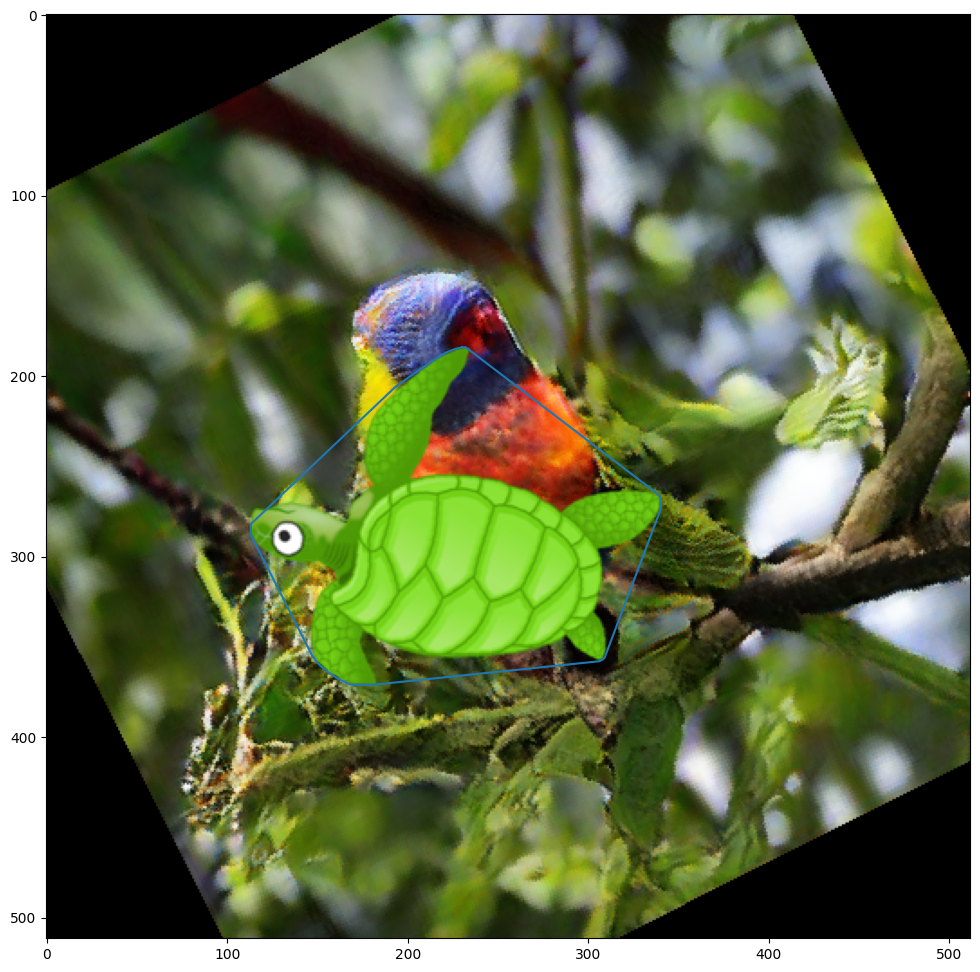

In [ ]:
def get_tight_polygon_from_mask(mask):
  # TODO: Implement an algorithm that computes the enclosing polygon from the segmentation mask.
    def distance(a, b):
        return (a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2

    coordinates = np.argwhere(mask)
    convex_hull = []
    lm = coordinates[0]
    for point in coordinates:
        if point[0] < lm[0]:
            lm = point
    a = lm
    while True:
        convex_hull.append(a)
        b = (a[0] + 1, a[1])
        for c in coordinates:
          val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
          if val <0 or (val == 0 and distance(a, c) > distance(a, b)):
              b = c
        a = b
        if (a == convex_hull[0]).all():
            break
    dummy_polygon_points_n2 = convex_hull
    return dummy_polygon_points_n2

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.numpy().transpose(1, 2, 0))
  plt.plot(xs.cpu().numpy(), ys.cpu().numpy())


polygon_points_n2_tensor = get_tight_polygon_from_mask(torch.Tensor.numpy(test_mask_tensor.cpu()))
visualize_polygon_on_image(test_image_tensor, torch.Tensor(polygon_points_n2_tensor.copy()))


# Task 3: Calculating the area of the polygon

<!-- > Indented block -->


*This is where you need to implement your area calculation algorithm. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Once again, treat this problem as a point-based rather than an image-based one.*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

**A = 1/2 [(x_1y_2 + x_2y_3) - (y_1x_2 + y_2x_3)]**

In [ ]:
def calculate_polygon_area(polygon_points_n2):
  # TODO: Implement the algorithm
  area = 0.0
  l = len(polygon_points_n2)
  if l>3:
    for p in range(l):
      x1,y1=polygon_points_n2[p]
      x2,y2 = polygon_points_n2[(p+1)%l]
      area += abs(x1 * y2 - x2 * y1)
    area /=2
  return area

print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))

Area = 73094.5000
